# Feedback from Meeting

<ul>

<li>Find an area to focus in!</li>
<li>Execute a set of projects from start to finish, then you can think through all the elements of how ideas impact colleagues and partners</li>
<li>Projects get money for specific purposes, general positions need unrestricted funding (precious)</li>

</ul>

# Considerations for Widgets, Layers

What are the parts that need to be filled in for each spec?

How to find out that information?

# Workflow and Access

<b>Can use docker containers with geotools to access and analyze RW data.</b>
<ul>
<li>Rutger's: https://hub.docker.com/r/rutgerhofste/gisdocker/</li>
<li>Alicia's: https://github.com/aagm/jupyter-geotools-alpine</li>
</ul>

<b>Mount one of these to an AWS or GCE environment with requisite space and computing power.</b>

<b>Maintain a clean resourcewatch/notebooks github repo.</b>
This will be where we point analysts, hackathon attendees, internal staff, for a readme and well-documented notebooks describing how to get started pulling and analyzing RW data on the cloud.

<b>EXTENSION: Create blog-style tutorials, similar to Carto MapAcademy.</b>
These could include discussion of how to use techniques liek MultiProcessing and MapReduce to handle big data.





# Widget Creation

<b>This notebook lays out a workflow for creating widgets for RW with vector and raster data.</b>

<ul>
<li>Vector on Vector</li>
<li>Raster on Vector</li>
<li>Raster on Raster</li>
<li>Vector Change over Time</li>
<li>Raster Change over Time</li>
</ul>


In [2]:
import os
import sys
#from timeit import timeit

import fiona
import geopandas as gpd
import pandas as pd
import numpy as np

from rasterio import features
import rasterio as rio
from affine import Affine

from shapely.geometry import Point, MultiPolygon, shape
from geopandas.tools import overlay, sjoin

import boto3

import subprocess

# Must run these commands
#root@53a2b43b08b5:/# jupyter nbextension install vega --py --sys-prefix
#root@53a2b43b08b5:/# jupyter nbextension enable vega --py --sys-prefix
from vega import Vega
import folium

from matplotlib import pyplot as plt
%matplotlib inline

data_pack_dir = os.getcwd()
print(data_pack_dir)
if data_pack_dir[-4:] != "pack":
    os.chdir("data_pack")
    data_pack_dir = os.getcwd()
    print("Now:", data_pack_dir)


/Aqueduct30Docker/notebooks
Now: /Aqueduct30Docker/notebooks/data_pack


In [52]:
s3 = boto3.client('s3')

In [62]:
# Vector datasets, all stored as zips
stored_vectors = ["wat_022_global_groundwater_vulnerability_floods_droughts.zip",
          "bio_004_coral_reef_extents.zip",
          "soc_020_gini_index_edit.zip",
          "wat_012_city_water_intakes.zip",
        "wat_001_baseline_water_stress.zip"]

vectors = []
# Raster datasets, all stored as geotiffs, some in folders
stored_rasters = ["com_012_global_shipping_lanes.tif",
                 ["bio_005_coral_reef_watch_bleaching_alerts","baa_max_r07d_b05kmnn_20170129_CRW_BAA_max7d.tif"],
                 "ene_018_wind_energy_potential.tif",
                 "ene_015_solar_energy_potential.tif"]

rasters = []

In [18]:
!mkdir data_pack
os.chdir("data_pack")
os.getcwd()

mkdir: cannot create directory 'data_pack': File exists


'/Aqueduct30Docker/notebooks/data_pack'

In [63]:
for v in vectors:
    bucket = "wri-projects"
    key = "resourcewatch/" + v
    file_name = v
    print(file_name)
    #timeit("s3.download_file(bucket,key,file_name)", number=1)
    s3.download_file(bucket,key,file_name)
    
for r in rasters:
    # Ran into file_name length constraints, can't include full path in name
    if type(r) == list:  
        bucket = "wri-projects"
        key = "resourcewatch/" + r[0] + "/" + r[1]
        file_name = r[1]
        print(key)
        print(file_name)
        #timeit("s3.download_file(bucket,key,file_name)", number=1)
        s3.download_file(bucket,key,file_name)
    else: 
        bucket = "wri-projects"
        key = "resourcewatch/" + r
        file_name = r
        print(key)
        print(file_name)
        #timeit("s3.download_file(bucket,key,file_name)", number=1)
        s3.download_file(bucket,key,file_name)

wat_001_baseline_water_stress.zip


# Vector on Vector

In [64]:
# Demo, unpack zip file, see if list layers work
!find . -name '*.zip' -exec unzip {} \;

# What is this __MACOSX folder? Is that causing the problem?

Archive:  ./wat_001_baseline_water_stress.zip
   creating: wat_001_baseline_water_stress/
  inflating: wat_001_baseline_water_stress/aqueduct_global_dl_20150409.cpg  
   creating: __MACOSX/wat_001_baseline_water_stress/
  inflating: __MACOSX/wat_001_baseline_water_stress/._aqueduct_global_dl_20150409.cpg  
  inflating: wat_001_baseline_water_stress/aqueduct_global_dl_20150409.dbf  
  inflating: __MACOSX/wat_001_baseline_water_stress/._aqueduct_global_dl_20150409.dbf  
  inflating: wat_001_baseline_water_stress/aqueduct_global_dl_20150409.prj  
  inflating: __MACOSX/wat_001_baseline_water_stress/._aqueduct_global_dl_20150409.prj  
  inflating: wat_001_baseline_water_stress/aqueduct_global_dl_20150409.shp  
  inflating: __MACOSX/wat_001_baseline_water_stress/._aqueduct_global_dl_20150409.shp  
  inflating: wat_001_baseline_water_stress/aqueduct_global_dl_20150409.shp.xml  
  inflating: __MACOSX/wat_001_baseline_water_stress/._aqueduct_global_dl_20150409.shp.xml  
  inflating: wat_001_bas

In [48]:
# Need to know shapefile name inside the zip folder... 
# should we rename these to be consistent with the folder name?
data_pack_dir = os.getcwd()
print(data_pack_dir)
if data_pack_dir[-4:] != "pack":
    os.chdir("data_pack")
    data_pack_dir = os.getcwd()
    print("Now:", data_pack_dir)

# Some have multiple shapefiles, need to list all available
vector_data_folder = "wat_012_city_water_intakes" #.zip for vfs
#fiona.listlayers("/", vfs="zip://"+data_pack_dir+"/" + vector_data_folder)
fiona.listlayers("./wat_012_city_water_intakes")

/Aqueduct30Docker/notebooks/data_pack


['Snapped_Withdrawal_Points',
 'Withdrawal_Points',
 'World_Watershed8',
 'City_Centroid']

In [31]:
city_water_intake_points = gpd.read_file("./"+vector_data_folder+"/Snapped_Withdrawal_Points.shp")
city_water_intake_points_city_centroids = gpd.read_file("./"+vector_data_folder+"/City_Centroid.shp")

In [49]:
layer1 = fiona.open("./"+vector_data_folder+"/Snapped_Withdrawal_Points.shp")
layer2 = fiona.open("./"+vector_data_folder+"/Withdrawal_Points.shp")
layer3 = fiona.open("./"+vector_data_folder+"/City_Centroid.shp")

In [41]:
pd.DataFrame(list(layer3))

,geometry,id,properties,type
0,"{'type': 'Point', 'coordinates': (144.92856328...",0,"{'NAME': 'Melbourne', 'City_ID': 213, 'ISOURBI...",Feature
1,"{'type': 'Point', 'coordinates': (174.76464443...",1,"{'NAME': 'Auckland', 'City_ID': 110, 'ISOURBID...",Feature
2,"{'type': 'Point', 'coordinates': (-73.05005319...",2,"{'NAME': 'Concepción', 'City_ID': 485, 'ISOURB...",Feature
3,"{'type': 'Point', 'coordinates': (-56.16708926...",3,"{'NAME': 'Montevideo', 'City_ID': 123, 'ISOURB...",Feature
4,"{'type': 'Point', 'coordinates': (-58.39177819...",4,"{'NAME': 'Buenos Aires', 'City_ID': 16, 'ISOUR...",Feature
5,"{'type': 'Point', 'coordinates': (18.439996596...",5,"{'NAME': 'Cape Town', 'City_ID': 125, 'ISOURBI...",Feature
6,"{'type': 'Point', 'coordinates': (151.27970762...",6,"{'NAME': 'Sydney', 'City_ID': 12, 'ISOURBID': ...",Feature
7,"{'type': 'Point', 'coordinates': (-70.65384252...",7,"{'NAME': 'Santiago', 'City_ID': 19, 'ISOURBID'...",Feature
8,"{'type': 'Point', 'coordinates': (-64.18447113...",8,"{'NAME': 'Córdoba', 'City_ID': 508, 'ISOURBID'...",Feature
9,"{'type': 'Point', 'coordinates': (-51.22173075...",9,"{'NAME': 'Pôrto Alegre', 'City_ID': 205, 'ISOU...",Feature


In [45]:
city_coords = pd.DataFrame(list(layer3))
city_coords.iloc[0]

geometry      {'type': 'Point', 'coordinates': (144.92856328...
id                                                            0
properties    {'NAME': 'Melbourne', 'City_ID': 213, 'ISOURBI...
type                                                    Feature
Name: 0, dtype: object

In [ ]:
# Having problem with kernel dying

top = city_water_intake_points.iloc[0:6]
top.head()
#print(top)
#city_water_intake_points.plot()

In [ ]:
print(city_water_intake_points_city_centroids.head())
city_water_intake_points_city_centroids.plot()

In [ ]:
# Point over Polygon with sjoin
join_left_df = sjoin(shape_file, point_file, how="left")

region_counts = join_left_df.groupby(["Group_column"]).count()["Count_column"]

# Write shapefile with region_counts

In [ ]:
# Format Vega Spec
# From: https://github.com/resource-watch/notebooks/blob/master/ResourceWatch/data_management/water-dashboard.ipynb

# Documentation on Vega: https://github.com/vega/ipyvega/
# Basic notebooks: https://github.com/vega/ipyvega/blob/master/notebooks/Vega.ipynb
# An option for formatting Vega-Lite schemas: https://altair-viz.github.io/documentation/displaying.html#displaying-plots-jupyter



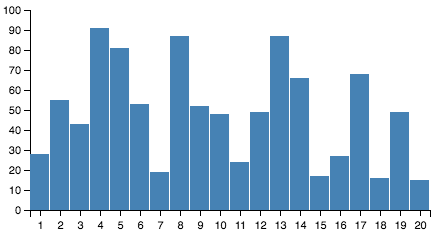

In [2]:
Vega({
  "width": 400,
  "height": 200,
  "padding": {"top": 10, "left": 30, "bottom": 30, "right": 10},
  "data": [
    {
      "name": "table",
      "values": [
        {"x": 1,  "y": 28}, {"x": 2,  "y": 55},
        {"x": 3,  "y": 43}, {"x": 4,  "y": 91},
        {"x": 5,  "y": 81}, {"x": 6,  "y": 53},
        {"x": 7,  "y": 19}, {"x": 8,  "y": 87},
        {"x": 9,  "y": 52}, {"x": 10, "y": 48},
        {"x": 11, "y": 24}, {"x": 12, "y": 49},
        {"x": 13, "y": 87}, {"x": 14, "y": 66},
        {"x": 15, "y": 17}, {"x": 16, "y": 27},
        {"x": 17, "y": 68}, {"x": 18, "y": 16},
        {"x": 19, "y": 49}, {"x": 20, "y": 15}
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "ordinal",
      "range": "width",
      "domain": {"data": "table", "field": "x"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "domain": {"data": "table", "field": "y"},
      "nice": True
    }
  ],
  "axes": [
    {"type": "x", "scale": "x"},
    {"type": "y", "scale": "y"}
  ],
  "marks": [
    {
      "type": "rect",
      "from": {"data": "table"},
      "properties": {
        "enter": {
          "x": {"scale": "x", "field": "x"},
          "width": {"scale": "x", "band": True, "offset": -1},
          "y": {"scale": "y", "field": "y"},
          "y2": {"scale": "y", "value": 0}
        },
        "update": {
          "fill": {"value": "steelblue"}
        },
        "hover": {
          "fill": {"value": "red"}
        }
      }
    }
  ]
})

# Raster on Vector

In [2]:
with rasterio.open('seasurfacetemp.tif', 'r') as raster:
    for ix in coral_reefs.index:
        if(ix%100 = 0):
            print(ix)
        geometry = coral_reefs.loc[ix, "geometry"]

        ul = raster.index(*geometry.bounds[0:2])
        lr = raster.index(*geometry.bounds[2:4])

        window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
        data = raster.read_band(1, window=window)

        t = raster.affine
        shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

        mask = features.rasterize(
                [(geometry, 0)],
                out_shape=data.shape,
                transform=shifted_affine,
                fill=1,
                all_touched=True,
                dtype=np.uint8)

        masked_data = np.ma.array(data=data, mask=mask.astype(bool))
        
        # instead of multiple indices, use the comma notation here to access vals
        # in df directly
        coral_reefs.loc[ix,"RasterMax"] = masked_data.max()
        coral_reefs.loc[ix,"RasterMin"] = masked_data.min()

SyntaxError: invalid syntax (<ipython-input-2-9f469595221a>, line 3)

# Energy / Water Dash

In [3]:
datasets = [
    "ene_018_wind_energy_potential.tif",
    "ene_015_solar_energy_potential.tif",
    "wat_001_baseline_water_stress"
]
fiona.listlayers("./wat_001_baseline_water_stress")
layer_name =fiona.listlayers("./wat_001_baseline_water_stress")[0]
layer = fiona.open("./wat_001_baseline_water_stress/" + layer_name + ".shp")

aq_shp = pd.DataFrame(list(layer))


In [41]:
[ct["COUNTRY"] for ct in aq_shp.loc[25008:]["properties"]]

['-1', '-1']

In [6]:
def extract_data(watershed, chosen_perc):
    geom = watershed["geometry"]
    props = watershed["properties"]
    energy_dist = watershed["Wind_Distribution"]
    
    data = {}
    data["shape"] = 
    data["id"] = watershed["id"]
    data["BWS"] = props["BWS"]
    data["Country"] = props["COUNTRY"]
    data["EnergyPerc"] = energy_dist[chosen_perc]
    
    return({
        "shape": shape(watershed["geometry"])
    })
    
aq_shp_sample = aq_shp.iloc[0:10]
print(aq_shp_sample)

new_df = []
for ix in aq_shp.index:
    new_df.append(extract_data(aq_shp.iloc[ix]))
    
watersheds = pd.DataFrame(new_df)
watersheds["id"]

                                            geometry id  \
0  {'coordinates': [[[(-14.752295656190142, 12.61...  0   
1  {'coordinates': [[[(-16.137677267978745, 12.29...  1   
2  {'coordinates': [[(-13.562381566112606, 12.667...  2   
3  {'coordinates': [[(-13.732176994830752, 12.578...  3   
4  {'coordinates': [[[(-15.72857010960513, 11.971...  4   
5  {'coordinates': [[[(-13.564825897353558, 11.43...  5   
6  {'coordinates': [[[(-13.96500114744606, 11.662...  6   
7  {'coordinates': [[[(-13.564825897353558, 11.43...  7   
8  {'coordinates': [[[(-14.84324947085804, 11.297...  8   
9  {'coordinates': [[[(-14.814268379053715, 11.35...  9   

                                          properties     type  
0  {'GU': 1, 'Shape_Leng': 0.559985678771, 'Shape...  Feature  
1  {'GU': 2, 'Shape_Leng': 2.272372216, 'Shape_Ar...  Feature  
2  {'GU': 3, 'Shape_Leng': 0.610378818449, 'Shape...  Feature  
3  {'GU': 4, 'Shape_Leng': 5.38496572297, 'Shape_...  Feature  
4  {'GU': 5, 'Shape_Leng': 1.8

0            0
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9
10          10
11          11
12          12
13          13
14          14
15          15
16          16
17          17
18          18
19          19
20          20
21          21
22          22
23          23
24          24
25          25
26          26
27          27
28          28
29          29
         ...  
24980    24980
24981    24981
24982    24982
24983    24983
24984    24984
24985    24985
24986    24986
24987    24987
24988    24988
24989    24989
24990    24990
24991    24991
24992    24992
24993    24993
24994    24994
24995    24995
24996    24996
24997    24997
24998    24998
24999    24999
25000    25000
25001    25001
25002    25002
25003    25003
25004    25004
25005    25005
25006    25006
25007    25007
25008    25008
25009    25009
Name: id, Length: 25010, dtype: object

In [ ]:
watersheds.loc[5872]

In [18]:
def find_raster_stats(watershed, raster):
    try:
        if( (int(watershed["id"]) % 1000 == 0)):
            print(watershed["id"])
            print(watershed["properties"]["COUNTRY"])
            print(watershed["properties"]["BWS"])
            
        #breaking_countries = ["Canada", "Russia", "Norway"]
        #if(watershed["properties"]["COUNTRY"] in breaking_countries):
        #    return("Breaking")
        
        geometry = shape(watershed["geometry"])
        ul = raster.index(*geometry.bounds[0:2])
        lr = raster.index(*geometry.bounds[2:4])

        window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
        data = raster.read_band(1, window=window)

        t = raster.affine
        shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

        mask = features.rasterize(
                [(geometry, 0)],
                out_shape=data.shape,
                transform=shifted_affine,
                fill=1,
                all_touched=True,
                dtype=np.uint8)

        masked_data = np.ma.array(data=data, mask=mask.astype(bool))
        
        mask_min = masked_data.min()
        mask_10_percentile = np.percentile(masked_data, 10)
        mask_20_percentile = np.percentile(masked_data, 20)
        mask_30_percentile = np.percentile(masked_data, 30)
        mask_40_percentile = np.percentile(masked_data, 40)
        mask_50_percentile = np.percentile(masked_data, 50)
        mask_60_percentile = np.percentile(masked_data, 60)
        mask_70_percentile = np.percentile(masked_data, 70)
        mask_80_percentile = np.percentile(masked_data, 80)
        mask_90_percentile = np.percentile(masked_data, 90)
        mask_max = masked_data.max()
        # instead of multiple indices, use the comma notation here to access vals
        # in df directly
        return([mask_min, mask_10_percentile, mask_20_percentile, mask_30_percentile,
               mask_40_percentile, mask_50_percentile, mask_60_percentile, mask_70_percentile,
               mask_80_percentile, mask_90_percentile, mask_max])
    except:
        return([None]*11)
    

In [16]:
lst = [0,1,2]
[lst[i] for i in [0,2]]



[0, 2]

In [92]:
with rio.open("./ene_018_wind_energy_potential.tif") as raster:
    aq_shp["Wind_Energy_Distribution"] = aq_shp.apply(lambda row: find_raster_stats(row, raster), axis=1)

0
Guinea Bissau
0.032105257809


/opt/anaconda3/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: read_band() is deprecated and will be removed by Rasterio 1.0. Please use read() instead.
  


1000
Argentina
0.00770774361438
2000
Angola
2.29905420032
3000
Democratic Republic of the Congo
0.00904403473195
4000
Australia
0.0162426484692
5000
Ireland
0.0650670518187
6000
Canada
0.0
7000
Mexico
0.102054187478
8000
China
3.41298507393
9000
China
0.000245439148312
10000
Turkmenistan
0.0183620899814
11000
Iraq
2.46933523703
12000
Spain
0.446968222866
13000
United States of America
0.0844096916159
14000
Russia
0.0
15000
Russia
0.000318698808391
16000
Argentina
0.0690252423911
17000
Peru
0.0106604946516
18000
Democratic Republic of the Congo
0.000930305184189
19000
Australia
0.0013975125468
20000
China
6.08583505153
21000
Iran
4.61564321767
22000
Nigeria
0.0159339426869
23000
United States of America
0.0102058460079
24000
Russia
0.00271919231883
25000
France
0.648319632554


In [100]:
def select_stats(stats, cols_to_keep):
    return([stats[col] for col in cols_to_keep])

aq_shp["Wind_Min"], aq_shp["Wind_10_Percentile"], aq_shp["Wind_Max"] = select_stats(list(zip(*aq_shp["Wind_Energy_Distribution"])), [0,1,10])

In [30]:
temp_vals

0         [3.9743, 3.97389085293, 4.08441]
1        [3.71503, 3.61055145264, 4.09949]
2         [4.35457, 4.37373962402, 4.5651]
3        [3.74626, 3.87316894531, 4.40546]
4        [3.75517, 3.75955593586, 4.06249]
5        [3.35001, 3.85511727333, 6.04987]
6         [3.68768, 3.8263676405, 4.73624]
7        [3.41098, 3.61046562195, 4.76208]
8         [3.58447, 3.7543289423, 4.42323]
9        [3.58447, 3.61046574116, 3.85603]
10       [3.58192, 3.67337155342, 4.39172]
11       [3.14351, 3.32215306759, 4.11627]
12       [2.90162, 3.18235721588, 4.60386]
13       [2.82154, 3.32442426682, 5.73384]
14        [3.22006, 3.77618780136, 5.0778]
15       [3.61062, 3.73955142498, 4.70237]
16         [3.6034, 3.64398231506, 4.2378]
17         [3.02924, 3.59829230309, 5.032]
18       [4.35919, 4.35923299789, 4.72482]
19        [3.17724, 3.52284326553, 4.9299]
20        [3.68462, 4.1130232811, 5.52749]
21       [3.42699, 3.59496023655, 4.96289]
22       [3.13332, 3.35855662823, 4.89587]
23       [3

In [101]:
aq_shp

,geometry,id,properties,type,Wind_Distribution,Wind_Max,Wind_Min,Wind_10_Percentile,Wind_Energy_Distribution,Wind_Min2,Wind_10_Percentile2,Wind_Max2
0,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",0,"{'GU': 1, 'Shape_Leng': 0.559985678771, 'Shape...",Feature,"[3.9743, 3.97389085293, 3.97464756966, 3.98720...",4.08441,3.9743,3.97389,"[3.9743, 3.97389085293, 3.97464756966, 3.98720...",3.9743,3.97389,4.08441
1,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",1,"{'GU': 2, 'Shape_Leng': 2.272372216, 'Shape_Ar...",Feature,"[3.71503, 3.61055145264, 3.71206870079, 3.7672...",4.09949,3.71503,3.61055,"[3.71503, 3.61055145264, 3.71206870079, 3.7672...",3.71503,3.61055,4.09949
2,"{'type': 'Polygon', 'coordinates': [[(-13.5623...",2,"{'GU': 3, 'Shape_Leng': 0.610378818449, 'Shape...",Feature,"[4.35457, 4.37373962402, 4.37616043091, 4.3864...",4.5651,4.35457,4.37374,"[4.35457, 4.37373962402, 4.37616043091, 4.3864...",4.35457,4.37374,4.5651
3,"{'type': 'Polygon', 'coordinates': [[(-13.7321...",3,"{'GU': 4, 'Shape_Leng': 5.38496572297, 'Shape_...",Feature,"[3.74626, 3.87316894531, 3.92943787575, 3.9867...",4.40546,3.74626,3.87317,"[3.74626, 3.87316894531, 3.92943787575, 3.9867...",3.74626,3.87317,4.40546
4,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",4,"{'GU': 5, 'Shape_Leng': 1.8151899509, 'Shape_A...",Feature,"[3.75517, 3.75955593586, 3.80301475525, 3.8213...",4.06249,3.75517,3.75956,"[3.75517, 3.75955593586, 3.80301475525, 3.8213...",3.75517,3.75956,4.06249
5,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",5,"{'GU': 6, 'Shape_Leng': 10.4915144826, 'Shape_...",Feature,"[3.35001, 3.85511727333, 4.02589464188, 4.1450...",6.04987,3.35001,3.85512,"[3.35001, 3.85511727333, 4.02589464188, 4.1450...",3.35001,3.85512,6.04987
6,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",6,"{'GU': 7, 'Shape_Leng': 7.87201363302, 'Shape_...",Feature,"[3.68768, 3.8263676405, 3.8834915638, 3.947729...",4.73624,3.68768,3.82637,"[3.68768, 3.8263676405, 3.8834915638, 3.947729...",3.68768,3.82637,4.73624
7,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",7,"{'GU': 8, 'Shape_Leng': 6.82377224976, 'Shape_...",Feature,"[3.41098, 3.61046562195, 3.71145157814, 3.7747...",4.76208,3.41098,3.61047,"[3.41098, 3.61046562195, 3.71145157814, 3.7747...",3.41098,3.61047,4.76208
8,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",8,"{'GU': 9, 'Shape_Leng': 2.16958601504, 'Shape_...",Feature,"[3.58447, 3.7543289423, 3.81641120911, 3.86741...",4.42323,3.58447,3.75433,"[3.58447, 3.7543289423, 3.81641120911, 3.86741...",3.58447,3.75433,4.42323
9,"{'type': 'MultiPolygon', 'coordinates': [[[(-1...",9,"{'GU': 10, 'Shape_Leng': 0.525756581347, 'Shap...",Feature,"[3.58447, 3.61046574116, 3.62928409576, 3.6466...",3.85603,3.58447,3.61047,"[3.58447, 3.61046574116, 3.62928409576, 3.6466...",3.58447,3.61047,3.85603


In [46]:
#cols = ["Wind_Max", "Wind_Min", "Wind_10_Percentile"]
#aq_shp.to_csv("Wind_Max_Min_10perc", columns=cols)

In [105]:
def check_null_or_zero(val):
    if(val == None):
        val = 0
    return(val if val > 0 else 0)

def extract_data(watershed):
    return({
        "Wind_Max": check_null_or_zero(watershed["Wind_Max"]),
        "Wind_Min": check_null_or_zero(watershed["Wind_Min"]),
        "Wind_10_Perc": check_null_or_zero(watershed["Wind_10_Percentile"]),
        "Baseline_Water_Stress": check_null_or_zero(watershed["properties"]["BWS"])
    })

res = aq_shp.apply(lambda row: extract_data(row), axis=1)
pd.DataFrame(list(res)).to_csv("Wind_Max_Min_10perc_no_null.csv")


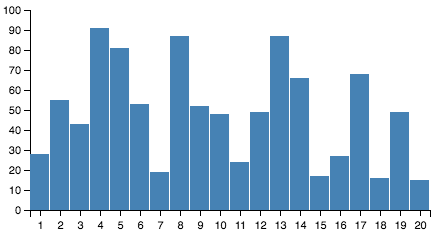

In [60]:
Vega({
  "width": 400,
  "height": 200,
  "padding": {"top": 10, "left": 30, "bottom": 30, "right": 10},
  "data": [
    {
      "name": "table",
      "values": [
        {"x": 1,  "y": 28}, {"x": 2,  "y": 55},
        {"x": 3,  "y": 43}, {"x": 4,  "y": 91},
        {"x": 5,  "y": 81}, {"x": 6,  "y": 53},
        {"x": 7,  "y": 19}, {"x": 8,  "y": 87},
        {"x": 9,  "y": 52}, {"x": 10, "y": 48},
        {"x": 11, "y": 24}, {"x": 12, "y": 49},
        {"x": 13, "y": 87}, {"x": 14, "y": 66},
        {"x": 15, "y": 17}, {"x": 16, "y": 27},
        {"x": 17, "y": 68}, {"x": 18, "y": 16},
        {"x": 19, "y": 49}, {"x": 20, "y": 15}
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "ordinal",
      "range": "width",
      "domain": {"data": "table", "field": "x"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "domain": {"data": "table", "field": "y"},
      "nice": True
    }
  ],
  "axes": [
    {"type": "x", "scale": "x"},
    {"type": "y", "scale": "y"}
  ],
  "marks": [
    {
      "type": "rect",
      "from": {"data": "table"},
      "properties": {
        "enter": {
          "x": {"scale": "x", "field": "x"},
          "width": {"scale": "x", "band": True, "offset": -1},
          "y": {"scale": "y", "field": "y"},
          "y2": {"scale": "y", "value": 0}
        },
        "update": {
          "fill": {"value": "steelblue"}
        },
        "hover": {
          "fill": {"value": "red"}
        }
      }
    }
  ]
})

In [ ]:
{
  "$schema": "https://vega.github.io/schema/vega/v3.0.json",
  "width": 200,
  "height": 200,
  "padding": 5,
  "autosize": "pad",

  "data": [
    {
      "name": "source",
      "url": "data/cars.json",
      "transform": [
        {
          "type": "filter",
          "expr": "datum['Horsepower'] != null && datum['Miles_per_Gallon'] != null && datum['Acceleration'] != null"
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "x",
      "type": "linear",
      "round": true,
      "nice": true,
      "zero": true,
      "domain": {"data": "source", "field": "Horsepower"},
      "range": [0,200]
    },
    {
      "name": "y",
      "type": "linear",
      "round": true,
      "nice": true,
      "zero": true,
      "domain": {"data": "source", "field": "Miles_per_Gallon"},
      "range": [200,0]
    },
    {
      "name": "size",
      "type": "linear",
      "round": true,
      "nice": false,
      "zero": true,
      "domain": {"data": "source", "field": "Acceleration"},
      "range": [4,361]
    }
  ],

  "axes": [
    {
      "scale": "x",
      "grid": true,
      "domain": false,
      "orient": "bottom",
      "tickCount": 5,
      "title": "Horsepower"
    },
    {
      "scale": "y",
      "grid": true,
      "domain": false,
      "orient": "left",
      "titlePadding": 5,
      "title": "Miles_per_Gallon"
    }
  ],

  "legends": [
    {
      "size": "size",
      "title": "Acceleration",
      "format": "s",
      "encode": {
        "symbols": {
          "update": {
            "strokeWidth": {"value": 2},
            "opacity": {"value": 0.5},
            "stroke": {"value": "#4682b4"},
            "shape": {"value": "circle"}
          }
        }
      }
    }
  ],

  "marks": [
    {
      "name": "marks",
      "type": "symbol",
      "from": {"data": "table"},
      "encode": {
        "update": {
          "x": {"scale": "x", "field": "Horsepower"},
          "y": {"scale": "y", "field": "Miles_per_Gallon"},
          "size": {"scale": "size", "field": "Acceleration"},
          "shape": {"value": "circle"},
          "strokeWidth": {"value": 2},
          "opacity": {"value": 0.5},
          "stroke": {"value": "#4682b4"},
          "fill": {"value": "transparent"}
        }
      }
    }
  ]
}

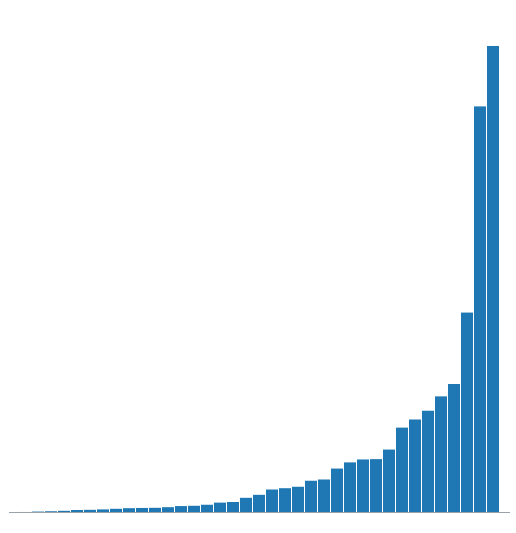

In [69]:
Vega({
  "scales": [
    {
      "domain": {
        "field": "x",
        "data": "table"
      },
      "range": "width",
      "type": "ordinal",
      "name": "x"
    },
    {
      "domain": {
        "field": "y",
        "data": "table"
      },
      "range": "height",
      "type": "linear",
      "nice": True,
      "name": "y"
    },
    {
      "range": "category10",
      "type": "ordinal",
      "name": "color"
    }
  ],
  "marks": [
    {
      "properties": {
        "update": {
          "fill": {
            "scale": "color"
          }
        },
        "hover": {
          "fill": {
            "scale": "color"
          }
        },
        "enter": {
          "width": {
            "offset": -1,
            "scale": "x",
            "band": True
          },
          "y2": {
            "value": 0,
            "scale": "y"
          },
          "y": {
            "scale": "y",
            "field": "y"
          },
          "x": {
            "scale": "x",
            "field": "x"
          }
        }
      },
      "type": "rect",
      "from": {
        "data": "table"
      }
    }
  ],
  "data": [
    {
      "url": "https://insights.carto.com/api/v2/sql?q=SELECT country as x, SUM(cap_rep) as y FROM grand_dams WHERE area_rep >= 477 AND area_rep <= 69000 GROUP BY x ORDER BY y asc LIMIT 100",
      "name": "table",
      "format": {
        "type": "json",
        "property": "rows"
      }
    }
  ],
  "legend": [
    {
      "type": "color",
      "label": None,
      "shape": "square",
      "values": [
        {
          "label": "Dam GRanD Area by Country",
          "type": "string",
          "value": "#1f77b4"
        }
      ]
    }
  ],
  "axes": [
    {
      "properties": {
        "labels": {
          "text": {
            "template": ""
          }
        },
        "axis": {
          "stroke": {
            "value": "#9BA2AA"
          }
        }
      },
      "tickSize": 0,
      "name": "Country",
      "scale": "x",
      "type": "x"
    },
    {
      "properties": {
        "labels": {
          "text": {
            "template": ""
          }
        },
        "axis": {
          "stroke": {
            "value": "transparent"
          }
        }
      },
      "tickSize": 0,
      "name": "Value",
      "scale": "y",
      "type": "y"
    }
  ]
})

In [106]:
Vega({
  "width": 200,
  "height": 200,
  "padding": 5,
  "autosize": "pad",

  "data": [
    {
      "name": "source",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT wind_max AS x, wind_10_perc as y FROM wind_max_min_10perc_no_null",
    }
  ],

  "scales": [
    {
      "name": "x",
      "type": "linear",
      "round": True,
      "nice": True,
      "zero": True,
      "domain": {"data": "source", "field": "x"},
      "range": [0,200]
    },
    {
      "name": "y",
      "type": "linear",
      "round": True,
      "nice": True,
      "zero": True,
      "domain": {"data": "source", "field": "y"},
      "range": [200,0]
    }
  ],

  "axes": [
    {
      "scale": "x",
      "grid": True,
      "domain": False,
      "orient": "bottom",
      "tickCount": 5,
      "title": "Horsepower"
    },
    {
      "scale": "y",
      "grid": True,
      "domain": False,
      "orient": "left",
      "titlePadding": 5,
      "title": "Miles_per_Gallon"
    }
  ],

  "legends": [
    
  ],

  "marks": [
    {
      "name": "marks",
      "type": "symbol",
      "from": {"data": "source"},
      "encode": {
        "update": {
          "x": {"scale": "x", "field": "x"},
          "y": {"scale": "y", "field": "y"},
          "shape": {"value": "circle"},
          "strokeWidth": {"value": 2},
          "opacity": {"value": 0.5},
          "stroke": {"value": "#4682b4"},
          "fill": {"value": "transparent"}
        }
      }
    }
  ]
})

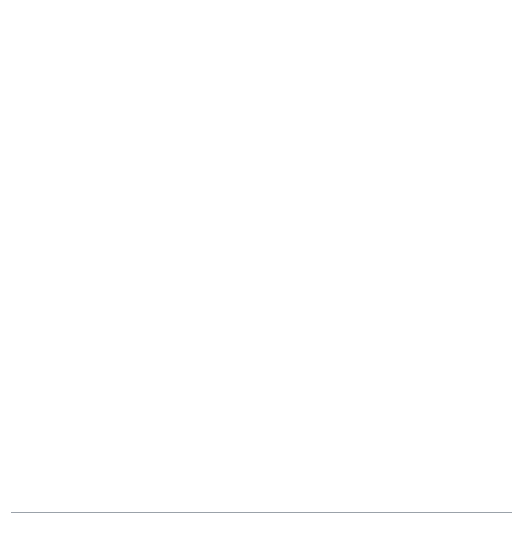

In [73]:
Vega({
  "scales": [
    {
      "domain": {
        "field": "x",
        "data": "table"
      },
      "range": "width",
      "type": "linear",
      "name": "x"
    },
    {
      "domain": {
        "field": "y",
        "data": "table"
      },
      "range": "height",
      "type": "linear",
      "nice": True,
      "name": "y"
    },
    {
      "range": "category10",
      "type": "ordinal",
      "name": "color"
    }
  ],
  "marks": [
    {
      "encode": {
        "update": {
          "fill": {
            "scale": "color"
          }
        }
      },
      "type": "symbol",
      "from": {"data": "table"},
      "name": "marks"
    }
  ],
  "data": [
    {
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT wind_max AS x, wind_10_perc as y FROM wind_max_min_10perc",
      "name": "table",
      "format": {
        "type": "json",
        "property": "rows"
      }
    }
  ],
  "legend": [
    {
      "type": "color",
      "label": None,
      "shape": "square",
      "values": [
        {
          "label": "Dam GRanD Area by Country",
          "type": "string",
          "value": "#1f77b4"
        }
      ]
    }
  ],
  "axes": [
    {
      "properties": {
        "labels": {
          "text": {
            "template": ""
          }
        },
        "axis": {
          "stroke": {
            "value": "#9BA2AA"
          }
        }
      },
      "tickSize": 0,
      "name": "Country",
      "scale": "x",
      "type": "x"
    },
    {
      "properties": {
        "labels": {
          "text": {
            "template": ""
          }
        },
        "axis": {
          "stroke": {
            "value": "transparent"
          }
        }
      },
      "tickSize": 0,
      "name": "Value",
      "scale": "y",
      "type": "y"
    }
  ]
})

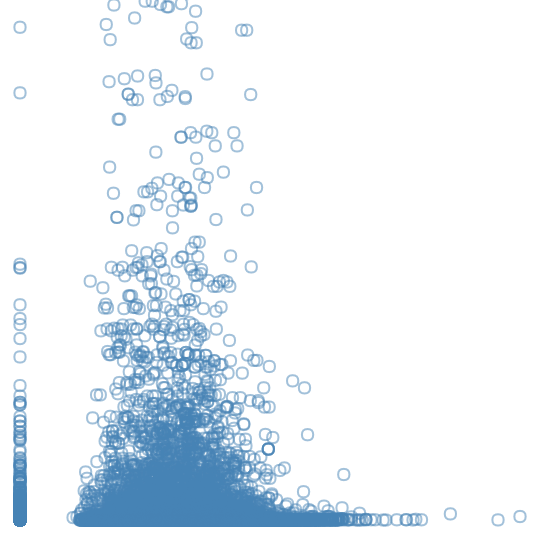

In [11]:
# Only works for showing 2 variable scatterplots

x_var = "wind_10_perc"
y_var = "baseline_water_stress"
table = "wind_max_min_10perc_no_null"
data_name = "wind_energy_water_stress"

config = {
    # View props - put in top level of config
    ## autosize: 
    ## background: <- represents entire view
    ## group: <- represents data rectangle, subset of view on which marks are drawn

    # Event props - put under "events" key
    ## defaults: single property, "prevent" or "allow" which dictate which events to 
    ### run event.preventDefault on
    
    # Mark props - put under "??"
    ## Sub-sets for different types of marks... 
    ### To set for just symbols {
        #  "symbol": {
        #    "fill": "steelblue",
        #    "size": 64
        #  }
        #}

}

Vega({
    "$schema": "https://vega.github.io/schema/vega/v3.0.json",
    "description": "A specification outline example.",
    
    "config": config,
    
    "width": 500,
    "height": 500,
    "padding": 20,
    "autosize": "fit",
    "signals": [],
    
    "data": [
        {
          "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT {}, {} FROM {}".format(x_var, y_var, table),
          "name": "{}".format(data_name),
          "format": {
            "type": "json",
            "property": "rows"
          }
        }
    ],
    
    "scales": [
        {
          "name": "xScale",
          "type": "linear",
          #"round": True,
          #"nice": True,
          "zero": True,
          "domain": {"data": "{}".format(data_name), "field": "{}".format(x_var)},
          "range": [0,500]
        },
        {
          "name": "yScale",
          "type": "linear",
          #"round": True,
          #"nice": True,
          "zero": True,
          #"domain": {"data": "wind_energy_water_stress", "field": "baseline_water_stress"},
          #"domain": {"data": "{}".format(data_name), "field": "{}".format(y_var)},
          "domain":[0,30],
          "range": "height"
        }
    ],
    
    "projections": [],
    "axes": [],
    "legends": [],

    "marks": [
        {
          "type": "symbol",
          "from": {"data": "{}".format(data_name)},
          "properties": {
            "update": {
              "x": {"scale":"xScale", "field": "{}".format(x_var)},
              "y": {"scale":"yScale", "field": "{}".format(y_var)},
              "shape": {"value": "circle"},
              "strokeWidth": {"value": 2},
              "opacity": {"value": 0.5},
              "stroke": {"value": "#4682b4"},
              "fill": {"value": "transparent"}
            }
          }
        }
    ]
})

# Raster on Raster

In [ ]:
# Need to explore reprojecting necessary to align tifs
# Liz Goldman suggests -> project larger raster down to maintain detail
# Can also aggregate smaller raster up

# Can polygonize raster of mapspam areas
# Overlay precipitation data

# Vector Change Over Time

In [ ]:
# TO DO
# 

# Raster Change Over Time

In [2]:
# TO DO
#